<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>


**CONTESTO:** *Fatal Police Shooting in the US*

L’omicidio del 2014 di Michael Brown a Ferguson, Missouri, ha dato origine a una protesta culminata nel movimento Black Lives Matter e al crescente interesse dell’opinione pubblica sull’affidabilità e il razzismo delle forze di polizia negli Stati Uniti.

Il Washington Post compila, da gennaio 2015, un database di tutti i casi di omicidio (da arma da fuoco) da parte della polizia negli Stati Uniti. A questo link (https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us) trovi un dataset pubblico di Kaggle che riporta, oltre a quello del Post, altri quattro database di informazioni demografiche. Il dataset di Kaggle si riferisce al periodo 2015-2016: a questo link (https://github.com/washingtonpost/data-police-shootings) trovi il database del Post aggiornato.

Infine, ecco un database (https://drive.google.com/file/d/1kEikaWCZYVO3ygVvAuVqxYqQPaVJrdYb/view) con la popolazione delle città USA.

**OBIETTIVO:** Analizzerai i dati inerenti ai casi di omicidio (da arma da fuoco) da parte della polizia negli Stati Uniti con lo scopo di evidenziare possibili bias razziali da parte della polizia.

A partire dai dati forniti ti sembra che la polizia americana uccida spoporzionatamente persone appartenenti ad un dato gruppo
prensente nella colonna 'race'?

**NOTA BENE:** Il lavoro va consegnato tenendo a mente che il notebook di Jupyter deve essere simile ad una presentazione da mostrare ad un ipotetico cliente: evitare notebook che siano troppo prolissi e ripetitivi nelle analisi. Scegliere cosa mostrare e perché mostrare quel concetto rispetto ad un altro è una delle capacità da sviluppare per questo workshop

# Importing data

In [1]:
#! pip install basemap
#! pip install basemap-data-hires

# Loading in required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.basemap import Basemap
import seaborn as sns

In [2]:
#Import relevant raw dataframes

policekillings_raw = pd.read_csv('fatal_police_shooting_data.csv')
shareracebycity_raw = pd.read_csv('ShareRaceByCity.csv')
populationbycity_raw = pd.read_csv('PopulationByCity.csv')
peoplebelowpoverty_raw = pd.read_csv('PercentagePeopleBelowPovertyLevel.csv',encoding="cp1252")
completionhighschool_raw = pd.read_csv('PercentOver25CompletedHighSchool.csv', encoding="cp1252")
medianhouseholdincome_raw = pd.read_csv('MedianHouseholdIncome2015.csv', encoding="cp1252")

policekillings_raw.info()
print('\n')
shareracebycity_raw.info()
print('\n')
populationbycity_raw.info()
print('\n')
peoplebelowpoverty_raw.info()
print('\n')
completionhighschool_raw.info()
print('\n')
medianhouseholdincome_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8166 entries, 0 to 8165
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          8166 non-null   int64  
 1   date                        8166 non-null   object 
 2   threat_type                 8163 non-null   object 
 3   flee_status                 7146 non-null   object 
 4   armed_with                  7956 non-null   object 
 5   city                        8157 non-null   object 
 6   county                      3310 non-null   object 
 7   state                       8166 non-null   object 
 8   latitude                    7300 non-null   float64
 9   longitude                   7300 non-null   float64
 10  location_precision          7300 non-null   object 
 11  name                        7679 non-null   object 
 12  age                         7637 non-null   float64
 13  gender                      8128 

# Data cleaning

In [3]:
#policekillings_raw Data Cleaning
policekillings_raw = policekillings_raw.drop(['id','flee_status','county','location_precision','name',
                              'race_source','was_mental_illness_related','body_camera','agency_ids'], axis=1)

policekillings = policekillings_raw.dropna(subset=['armed_with','age','race','latitude','longitude','gender','city']).reset_index(drop=True)
policekillings = policekillings[~policekillings['race'].isin(['B;H','O'])]
policekillings['year'] = policekillings['date'].str[:4].astype(int)

policekillings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6060 entries, 0 to 6079
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6060 non-null   object 
 1   threat_type  6060 non-null   object 
 2   armed_with   6060 non-null   object 
 3   city         6060 non-null   object 
 4   state        6060 non-null   object 
 5   latitude     6060 non-null   float64
 6   longitude    6060 non-null   float64
 7   age          6060 non-null   float64
 8   gender       6060 non-null   object 
 9   race         6060 non-null   object 
 10  year         6060 non-null   int32  
dtypes: float64(3), int32(1), object(7)
memory usage: 544.5+ KB


In [4]:
#shareracebycity_raw Data Cleaning

#Rename City with city in shareracebycity dataframe
shareracebycity_raw.rename(columns = {'City':'city'}, inplace = True)
shareracebycity_raw.rename(columns = {'Geographic area':'state'}, inplace = True)

# split shareracebycity series by whitespace and remove last element
shareracebycity_raw['city'] = shareracebycity_raw['city'].str.split().str[:-1].str.join(' ')
shareracebycity = shareracebycity_raw

#Convert share series from string to float
shareracebycity['share_white'] = pd.to_numeric(shareracebycity['share_white'], errors='coerce')
shareracebycity['share_black'] = pd.to_numeric(shareracebycity['share_black'], errors='coerce')
shareracebycity['share_native_american'] = pd.to_numeric(shareracebycity['share_native_american'], errors='coerce')
shareracebycity['share_asian'] = pd.to_numeric(shareracebycity['share_asian'], errors='coerce')
shareracebycity['share_hispanic'] = pd.to_numeric(shareracebycity['share_hispanic'], errors='coerce')

#Normalize share values

share_total = shareracebycity['share_white'] + shareracebycity['share_black'] + shareracebycity['share_native_american'] + shareracebycity['share_asian'] + shareracebycity['share_hispanic']
shareracebycity['share_white'] = shareracebycity['share_white']/share_total*100
shareracebycity['share_black'] = shareracebycity['share_black']/share_total*100
shareracebycity['share_native_american'] = shareracebycity['share_native_american']/share_total*100
shareracebycity['share_asian'] = shareracebycity['share_asian']/share_total*100
shareracebycity['share_hispanic'] = shareracebycity['share_hispanic']/share_total*100

shareracebycity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29268 entries, 0 to 29267
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  29268 non-null  object 
 1   city                   29268 non-null  object 
 2   share_white            29247 non-null  float64
 3   share_black            29247 non-null  float64
 4   share_native_american  29247 non-null  float64
 5   share_asian            29247 non-null  float64
 6   share_hispanic         29247 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.6+ MB


In [5]:
#populationbycity_raw Data Cleaning

populationbycity = populationbycity_raw.drop(['lat','lng'], axis=1)

populationbycity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2832 entries, 0 to 2831
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        2832 non-null   object 
 1   state       2832 non-null   object 
 2   population  2832 non-null   float64
dtypes: float64(1), object(2)
memory usage: 66.5+ KB


In [6]:
#peoplebelowpoverty_raw Data Cleaning

#Rename City with city in peoplebelowpoverty dataframe
peoplebelowpoverty_raw.rename(columns = {'City':'city'}, inplace = True)
peoplebelowpoverty_raw.rename(columns = {'Geographic Area':'state'}, inplace = True)

# split peoplebelowpoverty series by whitespace and remove last element
peoplebelowpoverty_raw['city'] = peoplebelowpoverty_raw['city'].str.split().str[:-1].str.join(' ')
peoplebelowpoverty = peoplebelowpoverty_raw

#Convert share series from string to float
peoplebelowpoverty['poverty_rate'] = pd.to_numeric(peoplebelowpoverty['poverty_rate'], errors='coerce')

peoplebelowpoverty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29329 entries, 0 to 29328
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   state         29329 non-null  object 
 1   city          29329 non-null  object 
 2   poverty_rate  29128 non-null  float64
dtypes: float64(1), object(2)
memory usage: 687.5+ KB


In [7]:
#completionhighschool_raw Data Cleaning

#Rename City with city in completionhighschool dataframe
completionhighschool_raw.rename(columns = {'City':'city'}, inplace = True)
completionhighschool_raw.rename(columns = {'Geographic Area':'state'}, inplace = True)

# split completionhighschool series by whitespace and remove last element
completionhighschool_raw['city'] = completionhighschool_raw['city'].str.split().str[:-1].str.join(' ')
completionhighschool = completionhighschool_raw

#Convert share series from string to float
completionhighschool['percent_completed_hs'] = pd.to_numeric(completionhighschool['percent_completed_hs'], errors='coerce')

completionhighschool.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29329 entries, 0 to 29328
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 29329 non-null  object 
 1   city                  29329 non-null  object 
 2   percent_completed_hs  29132 non-null  float64
dtypes: float64(1), object(2)
memory usage: 687.5+ KB


In [8]:
#medianhouseholdincome_raw Data Cleaning

medianhouseholdincome_raw = medianhouseholdincome_raw.dropna(subset=['Median Income']).reset_index(drop=True)

#Rename City with city in medianhouseholdincome dataframe
medianhouseholdincome_raw.rename(columns = {'City':'city'}, inplace = True)
medianhouseholdincome_raw.rename(columns = {'Geographic Area':'state'}, inplace = True)

# split medianhouseholdincome_ series by whitespace and remove last element
medianhouseholdincome_raw['city'] = medianhouseholdincome_raw['city'].str.split().str[:-1].str.join(' ')
medianhouseholdincome = medianhouseholdincome_raw

#Convert share series from string to float
medianhouseholdincome['Median Income'] = pd.to_numeric(medianhouseholdincome['Median Income'], errors='coerce')

medianhouseholdincome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29271 entries, 0 to 29270
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   state          29271 non-null  object 
 1   city           29271 non-null  object 
 2   Median Income  27385 non-null  float64
dtypes: float64(1), object(2)
memory usage: 686.2+ KB


In [9]:
#Merge policekillings with shareracebycity and populationbycity dataqframes
population_merged = pd.merge(shareracebycity, populationbycity, on=['city','state'], how='inner')
police_merged = pd.merge(policekillings, population_merged, on=['city','state'], how='inner')
poverty_merged = pd.merge(police_merged, peoplebelowpoverty, on=['city','state'], how='inner')
school_merged = pd.merge(poverty_merged, completionhighschool, on=['city','state'], how='inner')
killings_merged = pd.merge(school_merged, medianhouseholdincome, on=['city','state'], how='inner')

killings_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4994 entries, 0 to 4993
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   4994 non-null   object 
 1   threat_type            4994 non-null   object 
 2   armed_with             4994 non-null   object 
 3   city                   4994 non-null   object 
 4   state                  4994 non-null   object 
 5   latitude               4994 non-null   float64
 6   longitude              4994 non-null   float64
 7   age                    4994 non-null   float64
 8   gender                 4994 non-null   object 
 9   race                   4994 non-null   object 
 10  year                   4994 non-null   int32  
 11  share_white            4994 non-null   float64
 12  share_black            4994 non-null   float64
 13  share_native_american  4994 non-null   float64
 14  share_asian            4994 non-null   float64
 15  shar

# Plotting

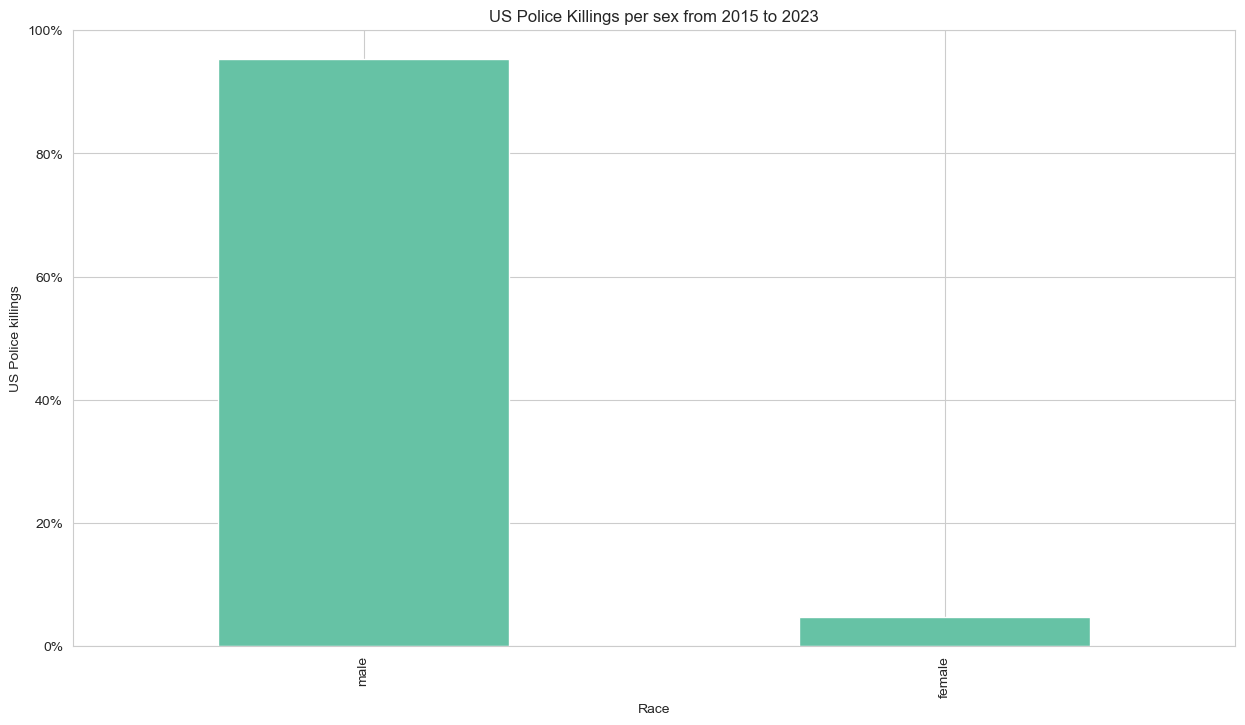

In [10]:
plt.figure(figsize = (15,8))

# Create a grouped bar chart using Seaborn
sns.set_style('whitegrid');
sns.set_palette('Set2');

ax = killings_merged['gender'].value_counts(normalize=True).plot(kind='bar');

plt.xlabel('Race');
plt.ylabel('US Police killings');
plt.title('US Police Killings per sex from 2015 to 2023');

# Adding %-formatting to the y-axis
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

Nel grafico a barre precedente viene riportata la percentuale di omicici da parte della polizia statunitense in base al genere. E' evidente che la maggior parte di persone uccise dal 2015 a oggi sono di genere maschile (95% uomini, 5 % donne)

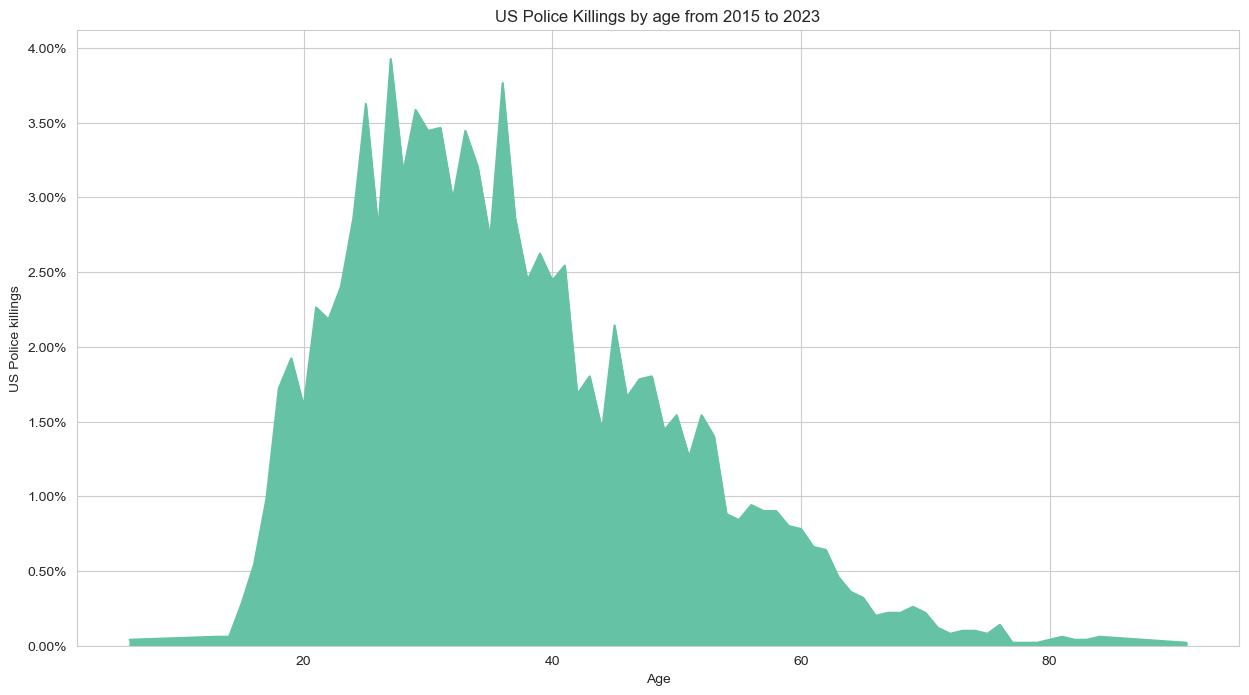

In [11]:
plt.figure(figsize = (15,8))

# Create a grouped bar chart using Seaborn
sns.set_style('whitegrid');
sns.set_palette('Set2');

ax = killings_merged['age'].value_counts(normalize=True).sort_index().plot(kind='area');

plt.xlabel('Age');
plt.ylabel('US Police killings');
plt.title('US Police Killings by age from 2015 to 2023');

# Adding %-formatting to the y-axis
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

Come visibile dal grafico a barre che precede, le vittime sono generalmente giovani fra i venti e i quarant'anni (moda 27 anni) con età minima 6 e massima 91 anni.

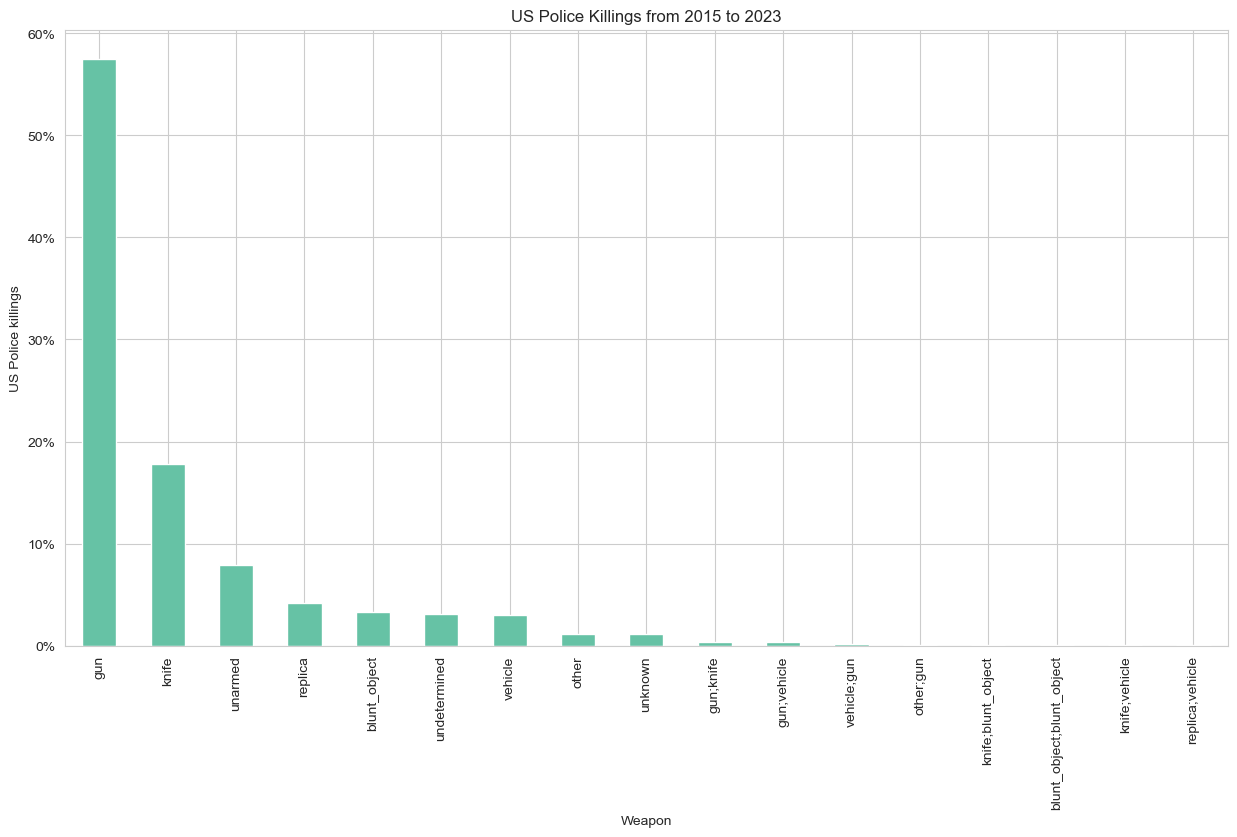

In [12]:
plt.figure(figsize = (15,8))

ax = killings_merged['armed_with'].value_counts(normalize=True).plot(kind='bar');

plt.xlabel('Weapon');
plt.ylabel('US Police killings');
plt.title('US Police Killings from 2015 to 2023');

# Adding %-formatting to the y-axis
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

Come evidente dal grafico a barre qui sopra, la maggior parte delle vittime della polizia statunitense dal 2015 ad oggi indossava una pistola (59%) o un coltello (18%) al momento dell'aggressione. Tuttavia una minima parte delle vittime non indossava alcun tipo di arma al momento dell'aggressione (7%).

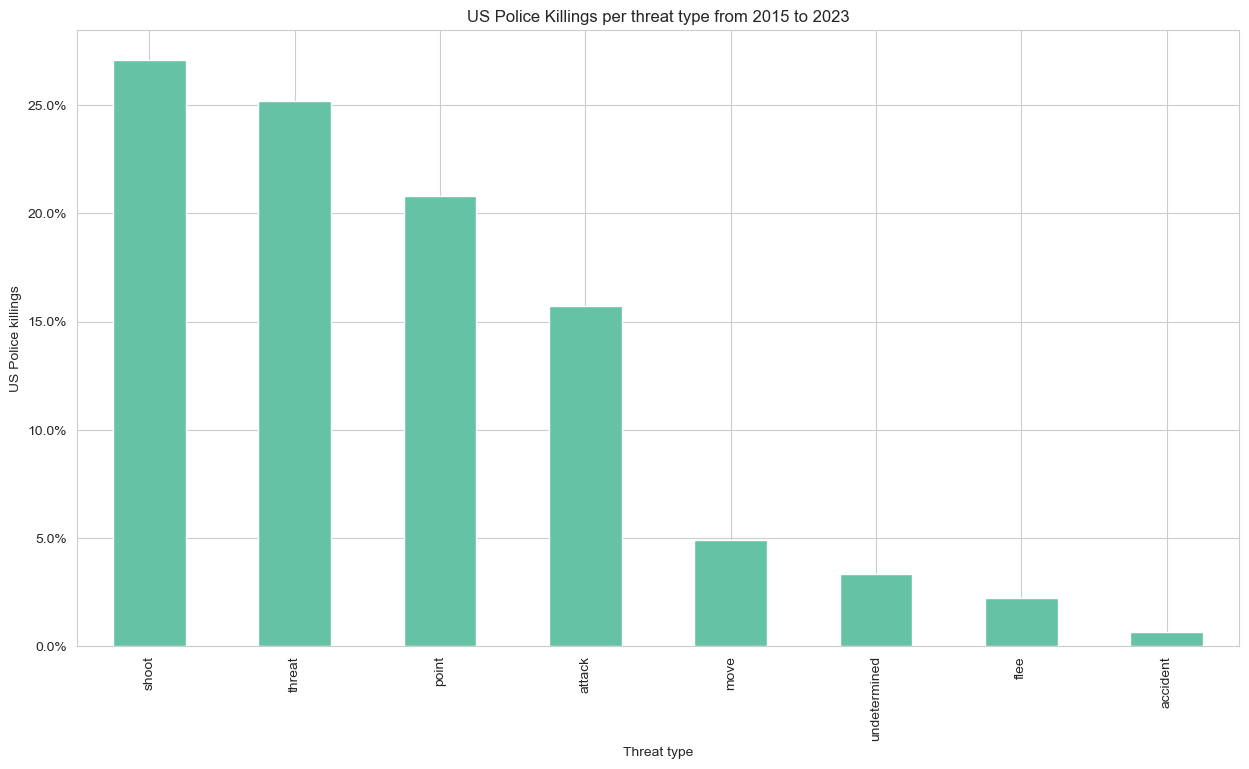

In [13]:
#plot threat type and threat type accident by race

plt.figure(figsize = (15,8))

ax = killings_merged['threat_type'].value_counts(normalize=True).plot(kind='bar');

plt.xlabel('Threat type');
plt.ylabel('US Police killings');
plt.title('US Police Killings per threat type from 2015 to 2023');

# Adding %-formatting to the y-axis
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

Nal grafico a barre precedente sono rappresentati tutti i casi di vittime della polizia statunitense dal 2015 al 2023 in funzione della tipologia di minaccia registrata. I casi più frequenti sono gli omicidi in seguito a colpo di arma da fuoco (28%), ma non sono rari i casi di omicidio in seguito a minaccia (26%), puntamento di arma ad un'altra persona (20%), attacco con altre armi o con la forza (15%) o movimento minaccioso (4%).

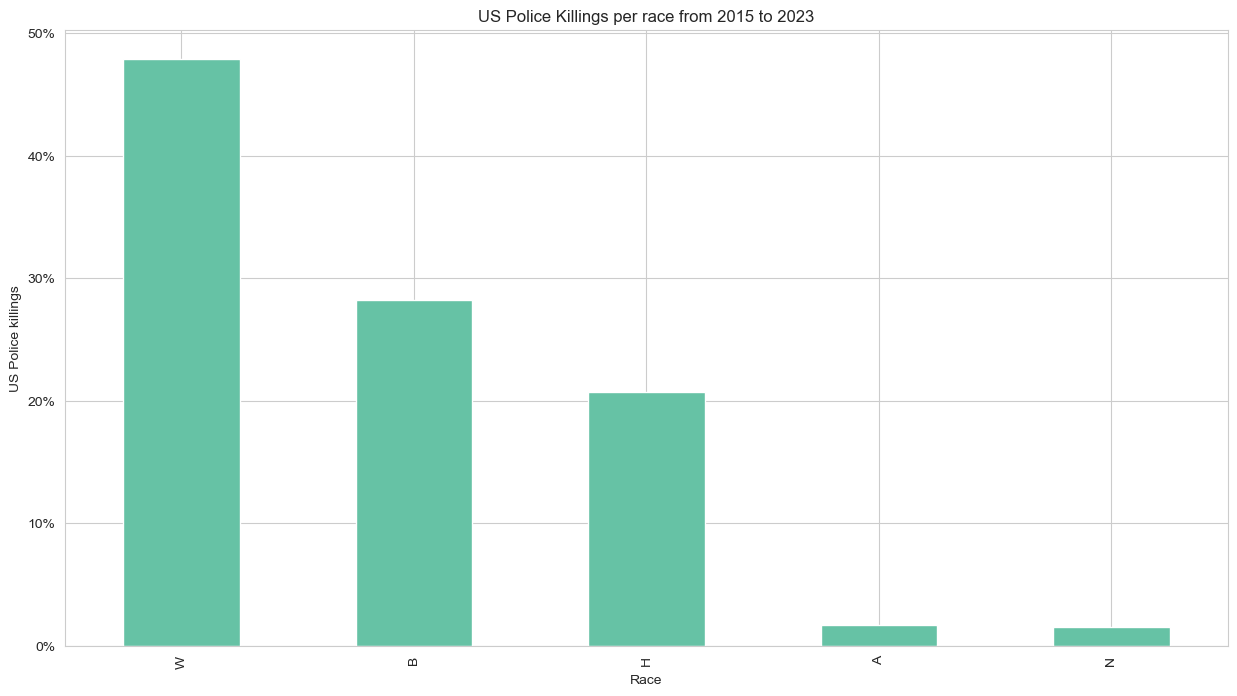

In [14]:
plt.figure(figsize = (15,8))

ax = killings_merged['race'].value_counts(normalize=True).plot(kind='bar');

plt.xlabel('Race');
plt.ylabel('US Police killings');
plt.title('US Police Killings per race from 2015 to 2023');

# Adding %-formatting to the y-axis
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

Nel grafico a barre qui sopra, viene evidenziata la percentuale di omicidi da parte della polizia statunitense in base al gruppo razziale/etnico di appartenenza della vittima. La maggioranza dei deceduti dal 2015 al 2023 è bianca (48% dei casi totali). Al secondo posto troviamo i neri (29% dei casi totali) e al terzo gli ispanici (20% dei casi totali). Asiatici e nativi americani contano il 2% ciascuno dei casi totali.

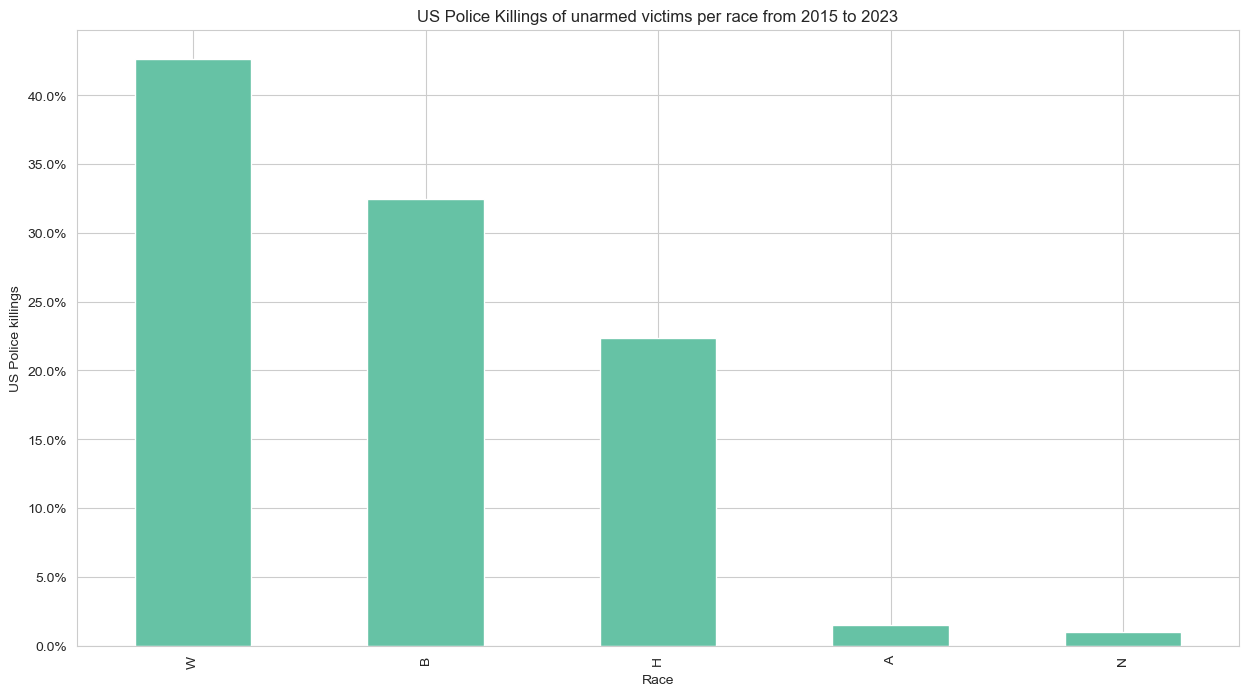

In [15]:
plt.figure(figsize = (15,8))

ax = killings_merged[killings_merged['armed_with'] == 'unarmed']['race'].value_counts(normalize=True).plot(kind='bar');

plt.xlabel('Race');
plt.ylabel('US Police killings');
plt.title('US Police Killings of unarmed victims per race from 2015 to 2023');

# Adding %-formatting to the y-axis
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

Il grafico a barre qui sopra mostra le percentuali di vittime non armate al momento dell'aggressione, suddivise per gruppo etnico/razziale. E' utile confrontare i valori percentuali con il grafico che precede.
Si nota in particolare una diminuzione del 6% sulla popolazione bianca ed un aumento del 5% sulla popolazione nera. Le variazioni sugli altri gruppi etnici sono dell'1% o inferiore.

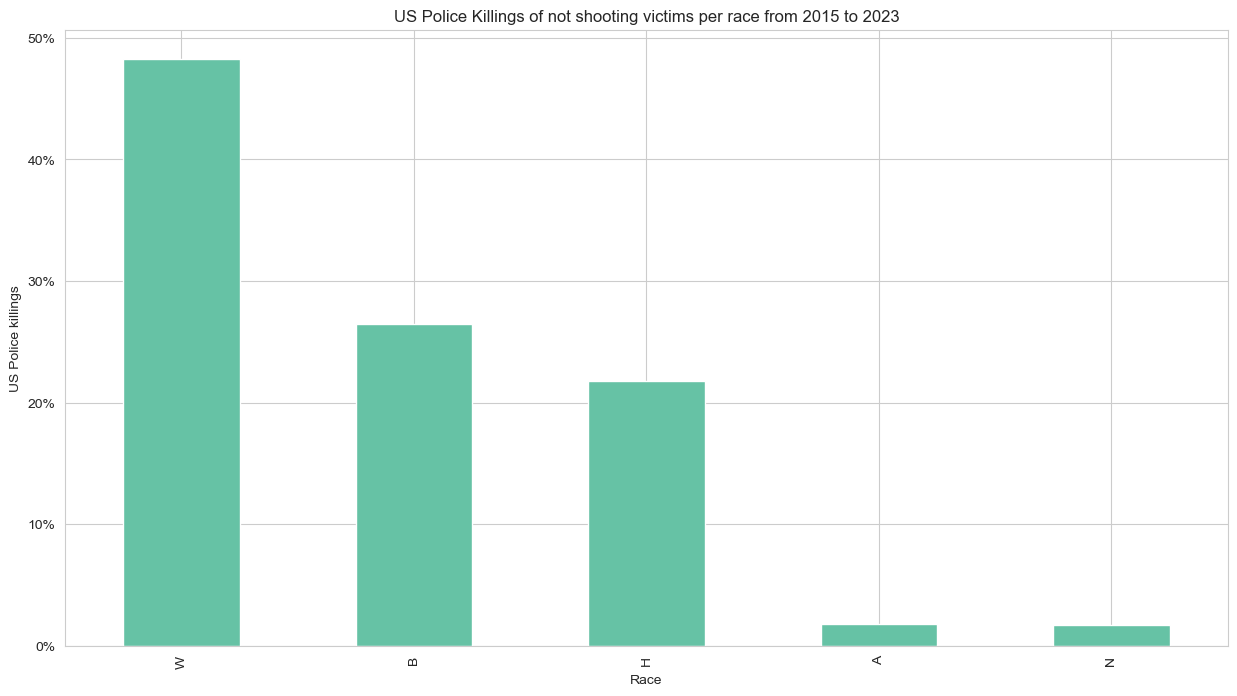

In [59]:
plt.figure(figsize = (15,8))

ax = killings_merged[(killings_merged['threat_type'] == 'threat') | (killings_merged['threat_type'] == 'point') | 
                     (killings_merged['threat_type'] == 'attack') | (killings_merged['threat_type'] == 'move') | 
                     (killings_merged['threat_type'] == 'undetermined') | (killings_merged['threat_type'] == 'flee') | 
                     (killings_merged['threat_type'] == 'accident')]['race'].value_counts(normalize=True).plot(kind='bar');

plt.xlabel('Race');
plt.ylabel('US Police killings');
plt.title('US Police Killings of not shooting victims per race from 2015 to 2023');

# Adding %-formatting to the y-axis
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

Nel grafico a barre sono rappresentati tutti i casi di omicidi da parte della polizia americana dove la vittima non ha sparato (ma può aver impugnato un'arma), suddivisi per appartenenza etnica/razziale del deceduto. E'interessante notare che non esiste un bias significativo rispetto ai casi totali rappresentati precedentemente. Le vittime nere non armate vengono uccise leggermente meno (-2%) rispetto alla popolazione totale. Non c'è invece una differenza significativa per la popolazione bianca e quella ispanica.

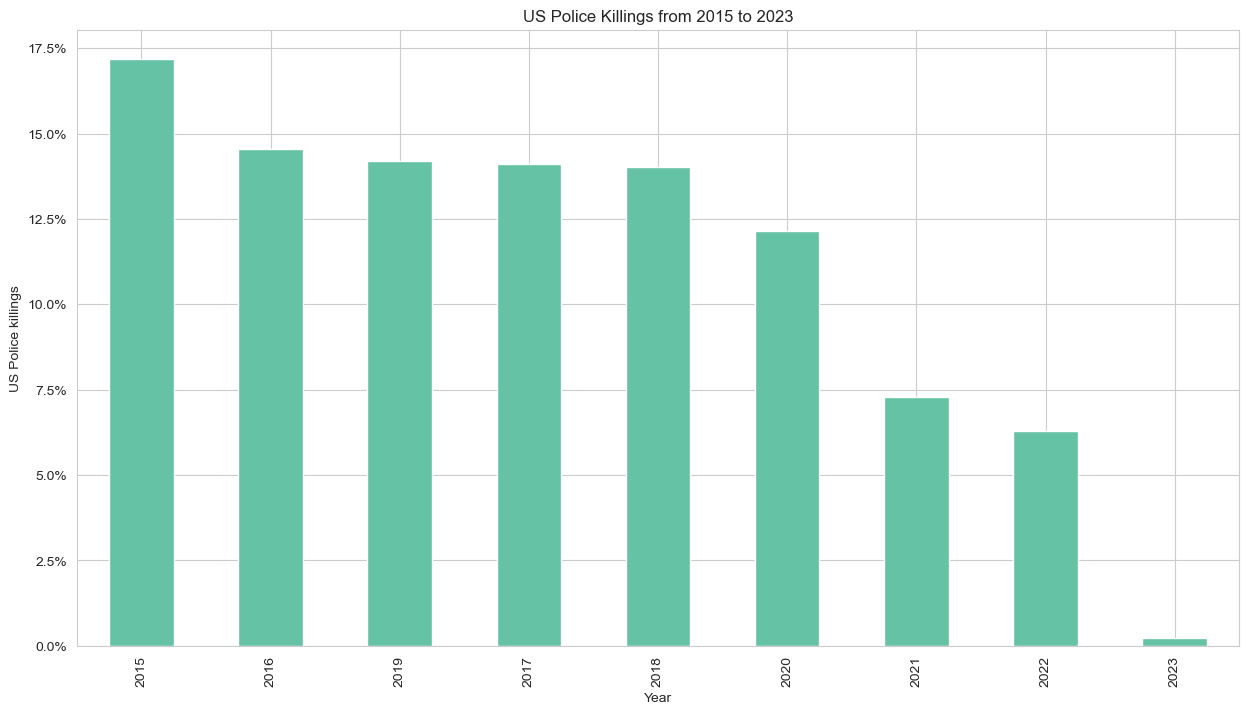

In [17]:
plt.figure(figsize = (15,8))

ax = killings_merged['year'].value_counts(normalize=True).plot(kind='bar');

plt.xlabel('Year');
plt.ylabel('US Police killings');
plt.title('US Police Killings from 2015 to 2023');

# Adding %-formatting to the y-axis
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

Nel grafico a barre precedente vengono riportati i casi di omicidio da parte della polizia statunitense per anno, dal 2015 al 2023. Dal 2015 a oggi si riscontra un calo degli omicidi del 63% che passano da 841 all'anno registrati nel 2015 a 313 all'anno registrati nel 2022. Il trend decrescente del numero di omicidi da parte della polizia registrati dal 2015 ad oggi è sistematico nel corso degli anni.

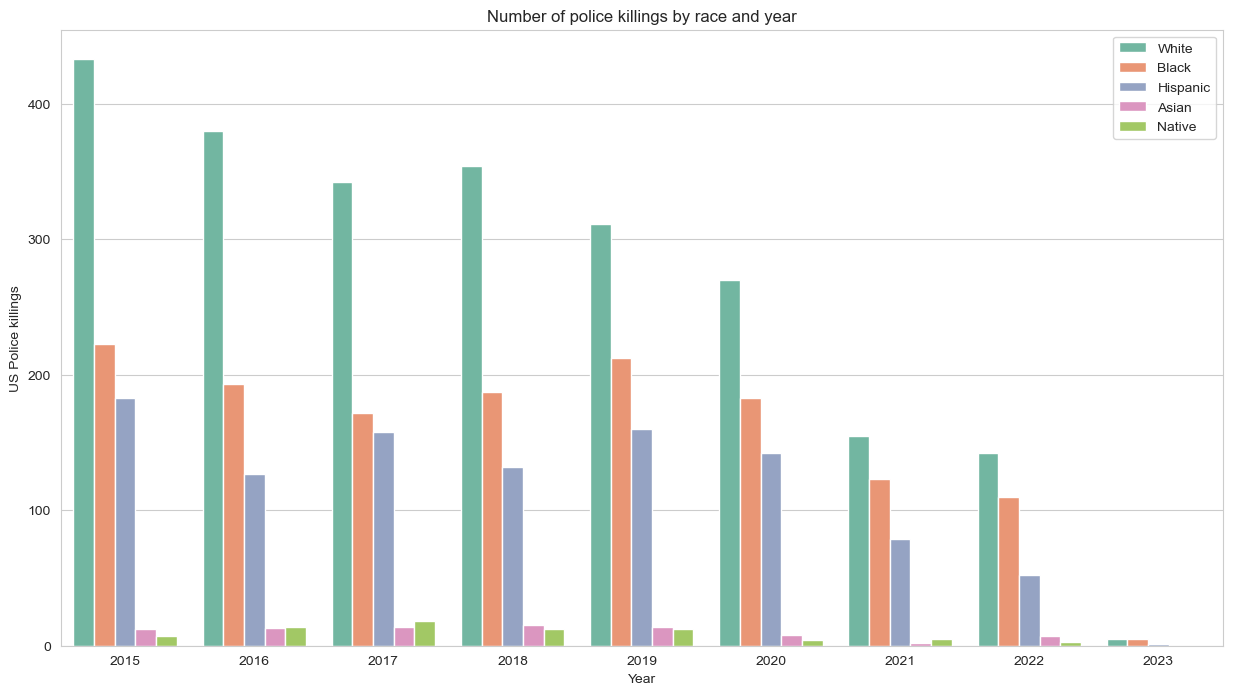

In [18]:
# Calculate the data for the bars
white_counts = killings_merged['year'][killings_merged['race'] == 'W'].value_counts()
black_counts = killings_merged['year'][killings_merged['race'] == 'B'].value_counts()
hispanic_counts = killings_merged['year'][killings_merged['race'] == 'H'].value_counts()
asian_counts = killings_merged['year'][killings_merged['race'] == 'A'].value_counts()
native_counts = killings_merged['year'][killings_merged['race'] == 'N'].value_counts()

# Convert the data to a long-format DataFrame
df = pd.DataFrame({'Year': white_counts.index.tolist() + black_counts.index.tolist() +
                   hispanic_counts.index.tolist() + asian_counts.index.tolist() +
                   native_counts.index.tolist(),
                   'Race': (['White']*len(white_counts) + ['Black']*len(black_counts) +
                            ['Hispanic']*len(hispanic_counts) + ['Asian']*len(asian_counts) +
                            ['Native']*len(native_counts)),
                   'Killings': (white_counts.tolist() + black_counts.tolist() +
                                  hispanic_counts.tolist() + asian_counts.tolist() +
                                  native_counts.tolist())})
plt.figure(figsize = (15,8))

# Create the plot using Seaborn
sns.barplot(x='Year', y='Killings', hue='Race', data=df)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('US Police killings')
plt.title('Number of police killings by race and year')

# aggiungi la legenda
plt.legend(loc='upper right')

# Show the plot
plt.show()

Nel grafico a barre precedente vengono rappresentati i casi di omicidio da parte della polizia statunitense per anno e appartenenza razziale/etnica della vittima. E'apprezzabile un calo degli omicidi di persone bianche dal 2015 al 2022 da 409 a 129 (-68%). Il calo degli omicidi di persone nere è comunque apprezzabile ma meno marcato, dai 213 del 2015 ai 109 del 2022 (-49%). Il calo di omicidi di persone appartenenti al gruppo ispanico è invece del 66% (da 155 nel 2015 a 52 nel 2022).

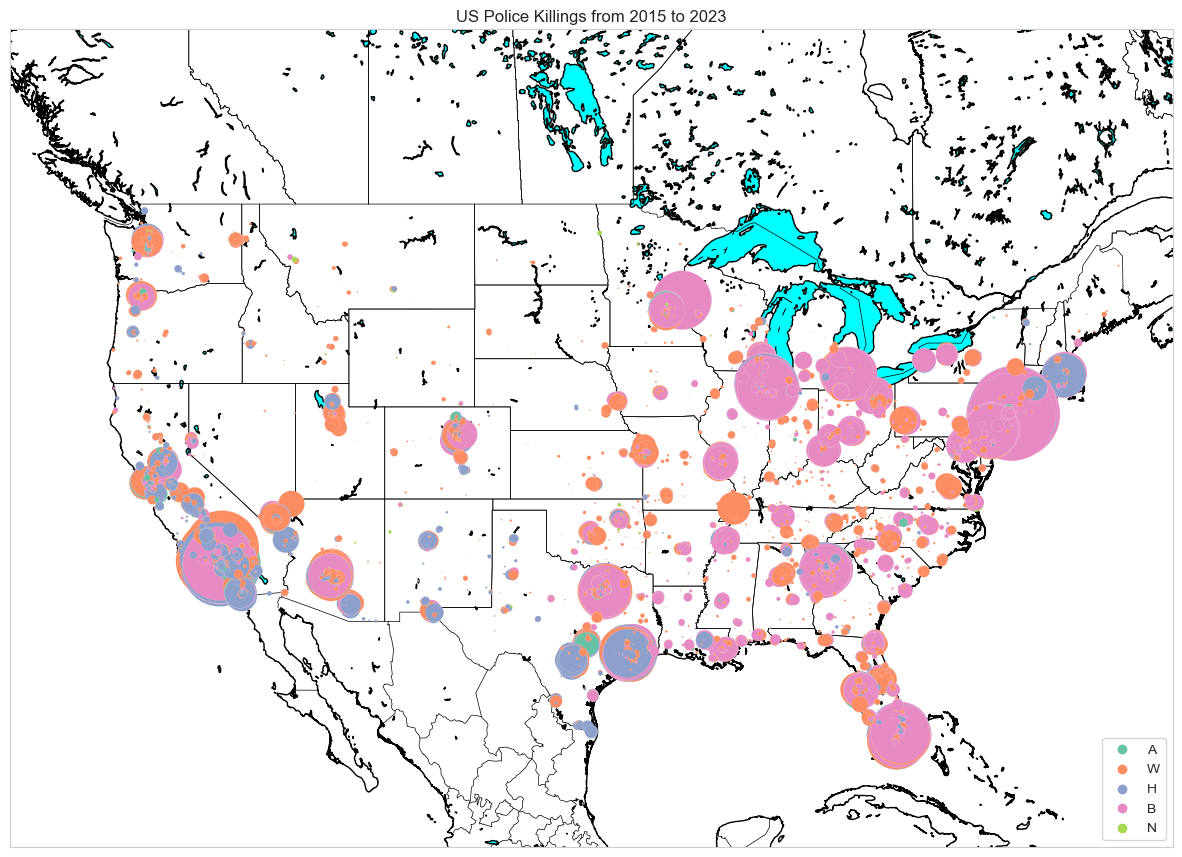

In [19]:
killings_merged['population_below_poverty_rate'] = killings_merged['poverty_rate'] * killings_merged['population'] /100; #population below poverty rate

fig = plt.figure(figsize=(15,12));

# creazione della mappa
m = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=55, llcrnrlon=-130, urcrnrlon=-65, resolution='h');

# disegno della mappa
m.drawcoastlines();
m.drawcountries();
m.drawstates();

# aggiunta del colore di sfondo
m.fillcontinents(color='white',lake_color='aqua');

sns.set_style(style='whitegrid');

# disegno dei punti
x, y = m(killings_merged['longitude'].values, killings_merged['latitude'].values);
sns.scatterplot(x=x, y=y, hue=killings_merged['race'], s=killings_merged['population_below_poverty_rate']/1000, zorder=10);

# aggiungi la legenda
plt.legend(loc='lower right')

plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.title('US Police Killings from 2015 to 2023');

Nel grafico che precede viene evidenziato il luogo degli omicidi con arma da fuoco da parte della polizia statunitense in funzione dell'appartenenza razziale della vittima. E' evidente che la maggior parte degli omicidi viene registrata nell'est degli Stati Uniti, dove la densità di punti è maggiore, con prevalenza di omicidi di persone appartenenti al gruppo etnico/razziale bianco e nero. Omicidi di persone di razza ispanica vengono registrati maggiormente nel sud del paese e sulla costa occidentale.
Il diametro dei cerchi indica la quota di popolazione sotto il livello di povertà. 
E' interessante evidenziare come molte delle località dove vengono uccisi neri da parte della polizia statunitense sono caratterizzati da un alto livello di povertà

In [20]:
#Calculating absolute values population per race

killings_merged['population_white'] = killings_merged['share_white']/100 * killings_merged['population']
killings_merged['population_black'] = killings_merged['share_black']/100 * killings_merged['population']
killings_merged['population_native_american'] = killings_merged['share_native_american']/100 * killings_merged['population']
killings_merged['population_asian'] = killings_merged['share_asian']/100 * killings_merged['population']
killings_merged['population_hispanic'] = killings_merged['share_hispanic']/100 * killings_merged['population']

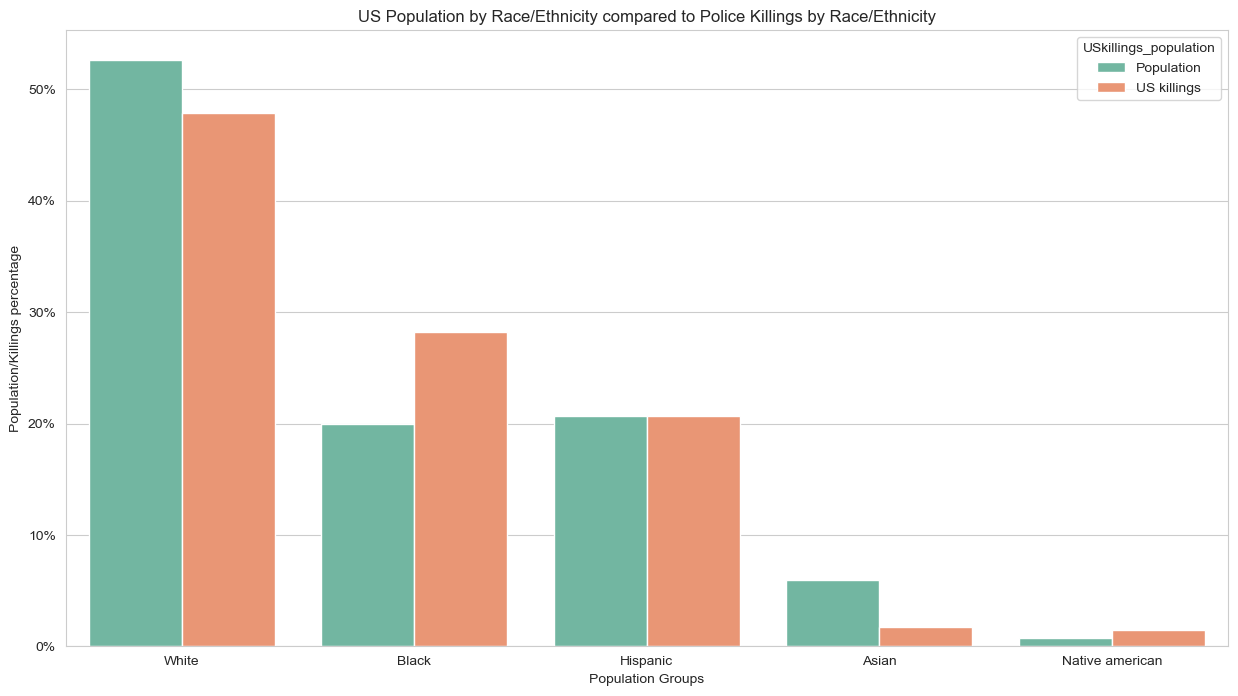

In [21]:
#Confronto percentuale fra popolazione e omicidi per appartenenza etnica/razziale

white_population = killings_merged['population_white'].unique().sum()
black_population = killings_merged['population_black'].unique().sum()
hispanic_population = killings_merged['population_hispanic'].unique().sum()
asian_population = killings_merged['population_asian'].unique().sum()
native_american_population = killings_merged['population_native_american'].unique().sum()

total_US_population = white_population + black_population + hispanic_population + asian_population + native_american_population

white_population = white_population/total_US_population*100
black_population = black_population/total_US_population*100
hispanic_population = hispanic_population/total_US_population*100
asian_population = asian_population/total_US_population*100
native_american_population = native_american_population/total_US_population*100

# Define the data
USkillingsbyrace = killings_merged['race'].value_counts(normalize=True)*100

# Convert the data to a long-format DataFrame
df = pd.DataFrame({'Race': ['White','White', 'Black','Black', 'Hispanic','Hispanic', 
                            'Asian','Asian', 'Native american', 'Native american'],
                   'USkillings_population': ['Population','US killings','Population','US killings', 
                            'Population','US killings','Population','US killings', 'Population','US killings'],
                   'Percentage': [white_population, USkillingsbyrace[0], black_population, USkillingsbyrace[1],
                                  hispanic_population, USkillingsbyrace[2], asian_population, USkillingsbyrace[3],
                                  native_american_population, USkillingsbyrace[4]]})

plt.figure(figsize = (15,8));

# Create a grouped bar chart using Seaborn
#sns.set_style('whitegrid');
#sns.set_palette('Set2');

sns.barplot(x='Race', y='Percentage', hue='USkillings_population', data= df);

# Format the y-axis as percentages
fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)

# Set the axis labels and title
plt.xlabel('Population Groups');
plt.ylabel('Population/Killings percentage');
plt.title('US Population by Race/Ethnicity compared to Police Killings by Race/Ethnicity');

# Display the plot
plt.show();

Nel grafico a barre in alto viene messa a confronto la composizione della popolazione statunitense per etnicità/razza con le percentuali di omicidi da parte della polizia statunitense, sempre suddivise per appartenenza razziale della vittima. A differenza degli omicidi di persone bianche, ispaniche, asiatiche e native americane (bianchi -5%, asiatici -4%, ispanici e nativi americani sotto l'1%) dove la differenza percentuale è minima, si riscontra un bias positivo di omicidi sui neri (+9%).

**Nota**: i risultati presentati non indicano necessariamente un bias razziale della polizia statunitense verso i neri. Andrebbe approfondita l'analisi, studiando la provenienza sociale, il reddito medio, il grado di scolarità e la propensione al crimine di ogni etnia/razza. 

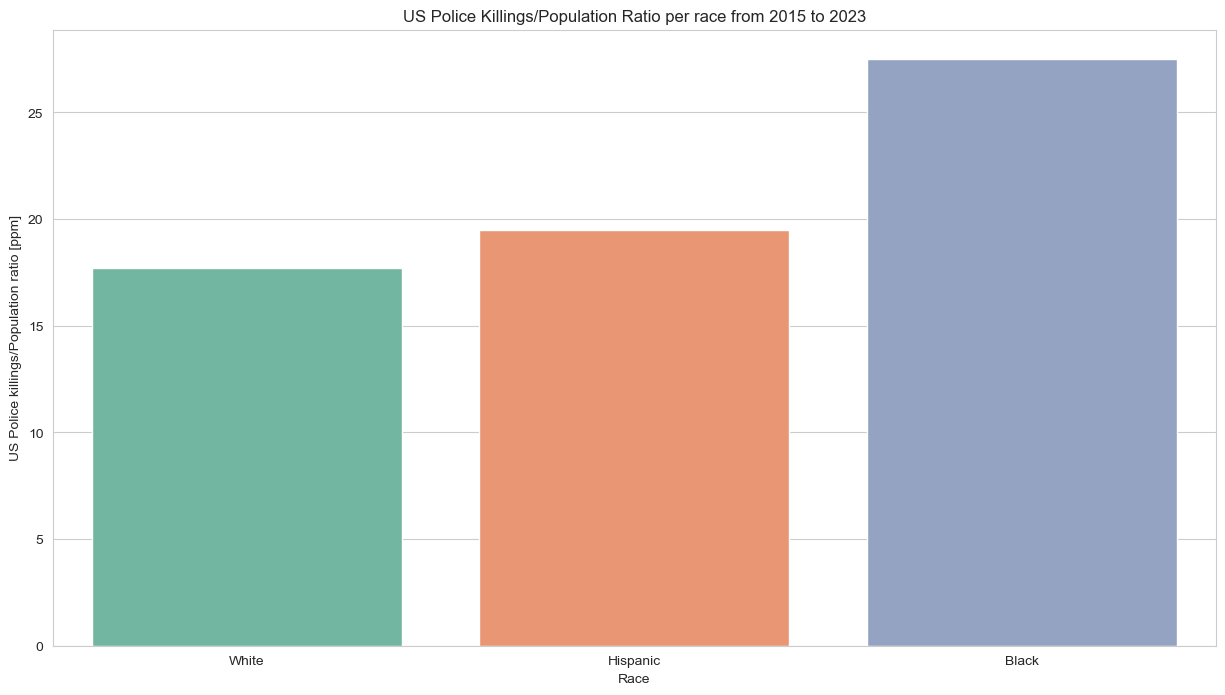

In [22]:
plt.figure(figsize = (15,8))

white_population = killings_merged['population_white'].unique().sum()
black_population = killings_merged['population_black'].unique().sum()
hispanic_population = killings_merged['population_hispanic'].unique().sum()
#asian_population = killings_merged['population_asian'].unique().sum()
#native_american_population = killings_merged['population_native_american'].unique().sum()

killings_white = killings_merged['race'].value_counts()[0]
killings_black = killings_merged['race'].value_counts()[1]
killings_hispanic = killings_merged['race'].value_counts()[2]
#killings_asian = killings_merged['race'].value_counts()[3]
#killings_native_american = killings_merged['race'].value_counts()[4]

ratio_killings = [0,0,0]

ratio_killings[0] = killings_white/white_population*10**6
ratio_killings[1] = killings_black/black_population*10**6
ratio_killings[2] = killings_hispanic/hispanic_population*10**6
#ratio_killings[3] = killings_asian/asian_population*100
#ratio_killings[4] = killings_native_american/native_american_population*100

# Convert the data to a long-format DataFrame
df = pd.DataFrame({'Race': ['White', 'Black', 'Hispanic'],
                   'ratio_killings': [ratio_killings[0], ratio_killings[1], ratio_killings[2]]})

result = df.groupby(['Race'])['ratio_killings'].median().reset_index().sort_values('ratio_killings')
sns.barplot(x='Race', y="ratio_killings", data=df, order=result['Race'])

# Format the y-axis as percentages
#fmt = '%.3f%%'
#yticks = mtick.FormatStrFormatter(fmt)
#plt.gca().yaxis.set_major_formatter(yticks)

plt.xlabel('Race');
plt.ylabel('US Police killings/Population ratio [ppm]');
plt.title('US Police Killings/Population Ratio per race from 2015 to 2023');

Nel grafico sopra vengono rappresentate le percentuali di omicidi per razza diviso la popolazione di appartenenza. E' interessante notare che il rapporto omicidi/popolazione nera è superiore del 55% rispetto al rapporto omicidi/popolazione bianca. Nel grafico non sono rappresentati gli asiatici e i nativi americani poichè il rapporto fra omicidi e popolazione potrebbe essere falsato dal basso numero di omicidi.

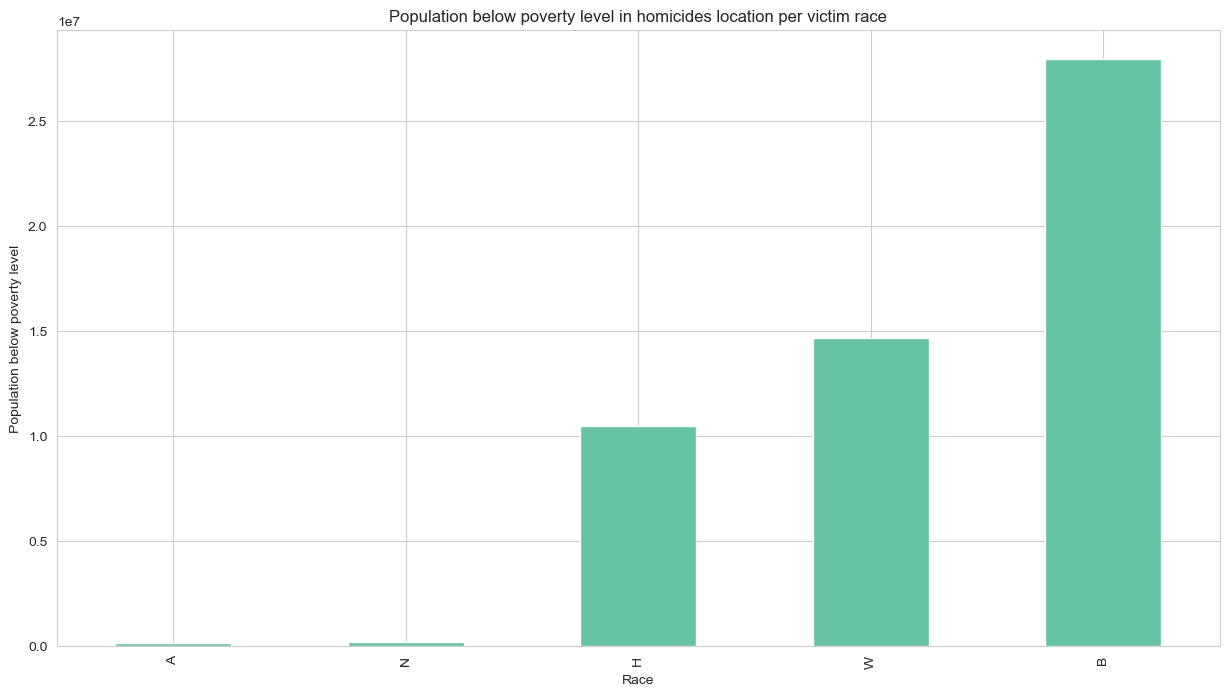

In [23]:
#Plot population below poverty rate in homicides location per victim race
plt.figure(figsize = (15,8))

killings_merged.drop_duplicates(subset=['city','state']).groupby('race')['population_below_poverty_rate'].sum().sort_values().plot(kind='bar')

plt.xlabel('Race');
plt.ylabel('Population below poverty level');
plt.title('Population below poverty level in homicides location per victim race');

In quest'ultimo grafico a barre viene rappresentata la popolazione sotto il livello di povertà nei luoghi dove sono stati commessi omicidi da parte della polizia statunitense, suddivisa per etnia/razza di appartenenza della vittima. Come visibile dal grafico sono più di 25 milioni gli americani sotto la soglia di povertà che nelle località dove sono stati uccisi dei neri da parte della polizia.

In [24]:
#Poverty Rate Analysis

#Correlation analysis
corr_matrix = killings_merged.corr()
corr_matrix['poverty_rate']

latitude                        -0.112276
longitude                        0.172525
age                             -0.021149
year                             0.021548
share_white                     -0.383286
share_black                      0.397367
share_native_american            0.076152
share_asian                     -0.211475
share_hispanic                   0.097697
population                       0.118239
poverty_rate                     1.000000
percent_completed_hs            -0.470957
Median Income                   -0.757531
population_below_poverty_rate    0.156242
population_white                 0.102043
population_black                 0.182552
population_native_american       0.091104
population_asian                 0.033900
population_hispanic              0.097839
Name: poverty_rate, dtype: float64

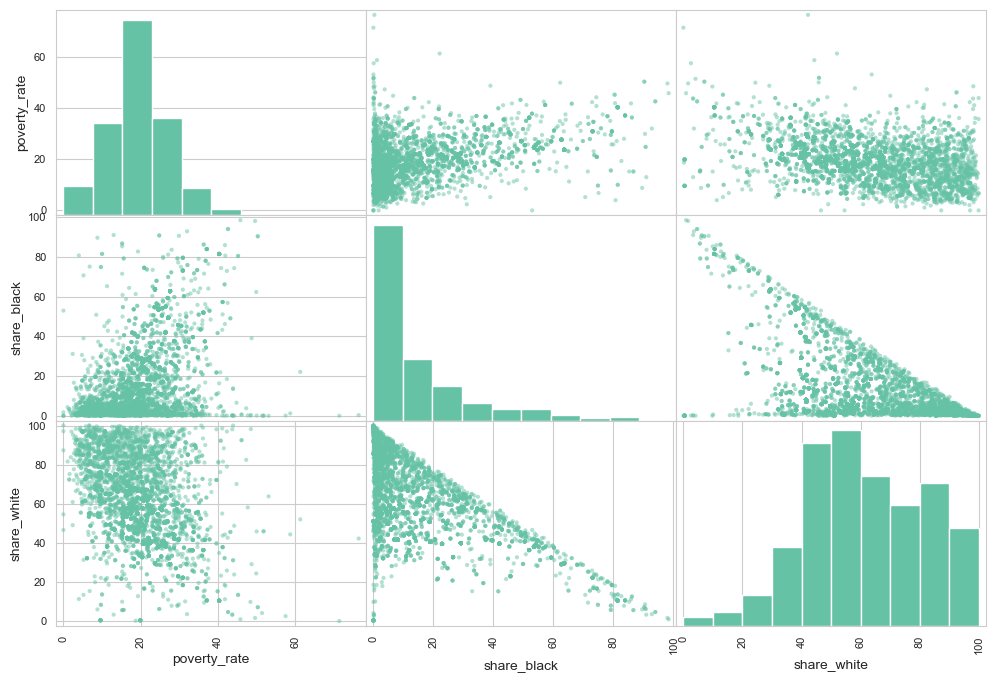

In [25]:
from pandas.plotting import scatter_matrix

attributes = ['poverty_rate','share_black', 'share_white']
scatter_matrix(killings_merged[attributes], figsize=(12,8))
plt.show()

Dalla matrice di correlazione è apprezzabile una correlazione positiva fra indice di povertà e share di popolazione nera, cioè all'aumentare della percentuale di popolazione nera aumenta l'indice di povertà di una località. Al contrario è apprezzabile una correlazione negativa fra indice di povertà e lo share di popolazione bianca, ovvero all'aumentare della percentuale di popolazione bianca diminuisce l'indice di povertà di una località.

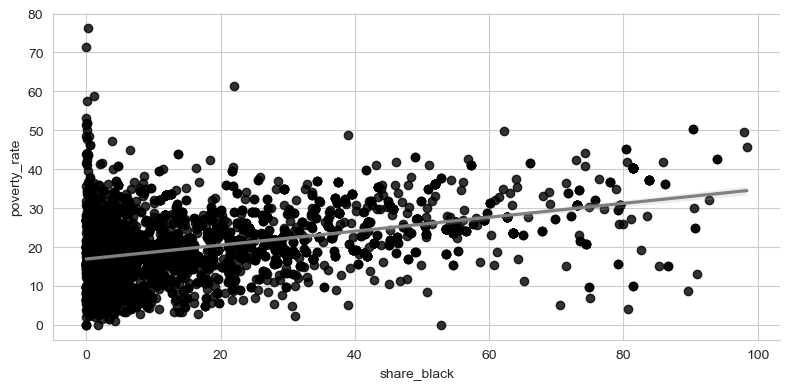

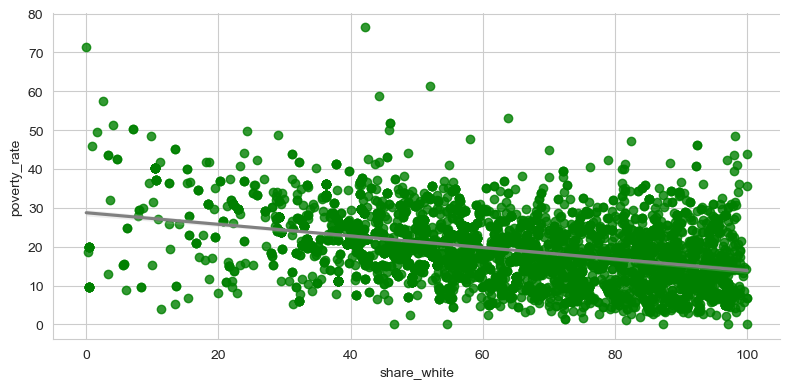

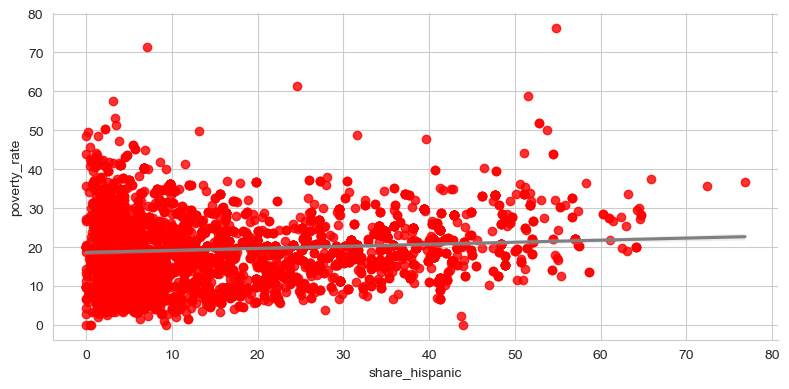

In [48]:
sns.lmplot(data=killings_merged, x='share_black', y='poverty_rate', 
           scatter_kws={"color": "black"}, line_kws={"color": "gray"}, height=4, aspect=2)

sns.lmplot(data=killings_merged, x='share_white', y='poverty_rate',
           scatter_kws={"color": "green"}, line_kws={"color": "gray"}, height=4, aspect=2)

sns.lmplot(data=killings_merged, x='share_hispanic', y='poverty_rate',
           scatter_kws={"color": "red"}, line_kws={"color": "gray"}, height=4, aspect=2)

plt.show()

Come già visibile dai coefficienti di correlazione calcolati in precedenza, è presente una discreta correlazione lineare fra lo share di popolazione nera ed il livello di povertà per ogni località considerata, in altre parole all'aumentare del gruppo etnico/razziale nero aumenta anche il grado di povertà. Al contrario per il gruppo etnico/razziale bianco è evidente una discreta correlazione lineare negativa, ovvero all'aumentare del gruppo etnico razziale bianco diminuisce il grado di povertà della popolazione. 

**Nota:** sarebbe utile analizzare tutti i crimini commessi negli Stati Uniti suddivisi per gruppo etnico/razziale al fine di comprendere meglio se il bias di omicidi di persone nere sia dovuto ad un eccesso di violenza da parte della polizia verso i neri oppure sia dovuto ad una maggiore propensione alla criminalità del gruppo in questione. 

Dai dati analizzati è tuttavia evidente che esiste una problematica di povertà diffusa nelle località dove vengono commessi omicidi da parte della polizia verso i neri e che la presenza di popolazione nera è discretamente correlata con il grado di povertà, a differenza della popolazione bianca che è inversamente correlata al grado di povertà.

Non sono state invece trovate delle prove a favore della tesi per cui esiste un problema di razzismo sistemico della polizia verso un particolare gruppo razziale.

**Nota:** un file csv aggiornato e completo può essere scaricato da questo sito: https://airtable.com/shroOenW19l1m3w0H/tblxearKzw8W7ViN8